In [1]:
import numpy as np
import matplotlib.pyplot as plt

equations are taken from https://www.mn.uio.no/math/personer/vit/karstent/mek4320/stokeswaves.pdf  
and https://link.springer.com/article/10.1007/s003480000229  
for ak > 0.2  and kh >> 1

Free surface (elevation):   

$\eta=a \cos \psi+\frac{1}{2} k a^2 \cos 2 \psi+\frac{3}{8} k^2 a^3 \cos 3 \psi$  
where  
$\psi=k x-\omega\left(1+\frac{1}{2}(k a)^2\right) t+\theta$  

Deep water dispersion relation  
$\omega^2=g k\left(1+a^2 k^2\right)$

Potential flow  and velocities:  
$\phi=\frac{g a}{\omega} \mathrm{e}^{k y} \sin(\psi) =\frac{a\omega}{k} \mathrm{e}^{k y} \sin(\psi)$   
$\vec{v} = (u,v) = \nabla \phi = (\frac{\partial \phi}{\partial x}, \frac{\partial \phi}{\partial y})$  
$u=\frac{\partial \phi}{\partial x} =a\omega\mathrm{e}^{k y}\cos(\psi)$  
$v=\frac{\partial \phi}{\partial y} =a\omega\mathrm{e}^{k y}\sin(\psi)$  

In [2]:
#only 1st and 2nd order
def get_k_from_dispersion_relation(amplitude, ang_freq, order):
    g = 9.81
    if order == 1:
        return (ang_freq**2)/g
    else:
        coefficients = [g*amplitude**2, g, -ang_freq**2]
        roots = np.roots(coefficients)
        positive = list(filter(lambda x: x.real > 0, roots))
        return positive[0].real
 

def get_psi(amplitude, wave_number, ang_freq,  x, t, order):
    psi = wave_number * x
    if order > 1:
        psi += ang_freq * t
    if order > 2:
        psi += ang_freq * 0.5*(wave_number * amplitude)**2 *t
    return psi
    
def get_elevation_data(amplitude, wave_number, ang_freq, x, t, order):
    psi = get_psi(amplitude, wave_number, ang_freq, x, t, order)
    eta = amplitude * np.cos(psi)
    if order > 1:
        eta += 0.5 * wave_number * amplitude**2 * np.cos(2*psi)
    if order > 2:
        eta += (3/8) * (wave_number**2) * (amplitude**3) * np.cos(3*psi)
    return eta

def get_velocity_components(amplitude, ang_freq, horiz_coord, vert_coord,  t, order):
    wave_number = get_k_from_dispersion_relation(amplitude, ang_freq, order)
    psi = get_psi(amplitude, wave_number, ang_freq, horiz_coord, t, order)
    factor_a = amplitude * ang_freq * np.exp(vert_coord * wave_number)
    u = factor_a * np.cos(psi)
    v = factor_a * np.sin(psi)
    return (u,v)
    


In [3]:
def plot_stokes_up_to3rd_order(wavemaker_amplitude, amplitude,  ampltude_std_dev, ang_freq, x, equal = False):
    k1 = get_k_from_dispersion_relation(amplitude, ang_freq, 1)
    k2 = get_k_from_dispersion_relation(amplitude, ang_freq, 1)
    eta1 = get_elevation_data(amplitude, k1, ang_freq, x, 0, 1) 
    eta2 = get_elevation_data(amplitude, k2, ang_freq, x, 0, 2) 
    eta3 = get_elevation_data(amplitude, k2, ang_freq, x, 0, 3)
    
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.axhline(y=0, linestyle='--', color='midnightblue') 
    ax.axhline(y=amplitude, linestyle='--', color='cornflowerblue', label = 'mean amplitude') 
    ax.fill_between(x, amplitude + ampltude_std_dev, amplitude - ampltude_std_dev, color='cornflowerblue', alpha=0.3,  label = 'standard deviation')
    ax.plot(x, eta1,linestyle='--', color = 'navy', label = "Stokes 1st order/linear")
    ax.plot(x, eta2, color = 'red', label = "Stokes_2nd_order",alpha = 0.5)
    ax.plot(x, eta3, color = 'black', label = "Stokes_3rd_order", alpha = 0.5)
    ax.set_title(f'Stokes wave profiles for k: {round(k2,3)} and amplitude: {round(amplitude,3)}[mm], wavemaker a: {wavemaker_amplitude}[V]', fontsize=14, )

    ax.set_ylabel('amplitude [m]', fontsize=12)
    ax.set_xlabel('x ', fontsize=12, )
    if equal:
        ax.set_aspect("equal")
    ax.legend()
    ax.grid()

In [4]:
def plot_velocity_profiles(wavemaker_amplitude, amplitude, ang_freq, depth):
    k1 = get_k_from_dispersion_relation(a1, ang_freq, 1)
    k2 = get_k_from_dispersion_relation(a1, ang_freq, 2)
    linear_lambda = 2* np.pi/k1
    # x is horizontal coordinate for wich crests happens - crest is every N * lambda, where N = 0, 1, 2, ... lambda = 2pi/k
    x1 = 2* np.pi/k1
    y = np.linspace(0, -depth, 100)
    u1, v1 = get_velocity_components(amplitude, ang_freq, x1, y,  0, 1)
    x2 = 2* np.pi/k2
    u2, v2 = get_velocity_components(amplitude, ang_freq, x2, y,  0, 2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
    fig.suptitle(f'Vertical profiles of u ad v velocity components of wave fluid motion, wavemaker a={wavemaker_amplitude}[V], a={round(amplitude,3)}, a*nonlin_k={round(amplitude*k2,3)}', fontsize=10)
    ax1.plot(u1/(amplitude*ang_freq), y/depth, color = 'navy',linestyle='--',  label = 'u linear')
    ax1.plot(u2/(amplitude*ang_freq), y/depth, color = 'red',alpha = 0.5,  label = 'Stokes 2nd order')
    ax1.set_title('Vertical profile of u component of particle under linear wave motion')
    ax1.set_xlabel('u/(a* ω) [m/s]')
    ax1.set_ylabel('y/h')
    ax1.legend()
    ax1.grid(True)
    
    plt.subplots_adjust(wspace=0.4)
    ax2.plot(v1/(amplitude*ang_freq), y/depth, color = 'navy', linestyle='--', label = 'v linear')
    ax2.plot(v2/(amplitude*ang_freq), y/depth, color = 'red', alpha=0.5, label = 'Stokes 2nd order')
    ax2.set_title('Vertical profile of v component of particle under  wave motion')
    
    ax2.set_xlabel('v/(a* ω) [m/s]')
    ax2.set_ylabel('y/h')
    ax2.legend()
    ax2.grid(True)

    

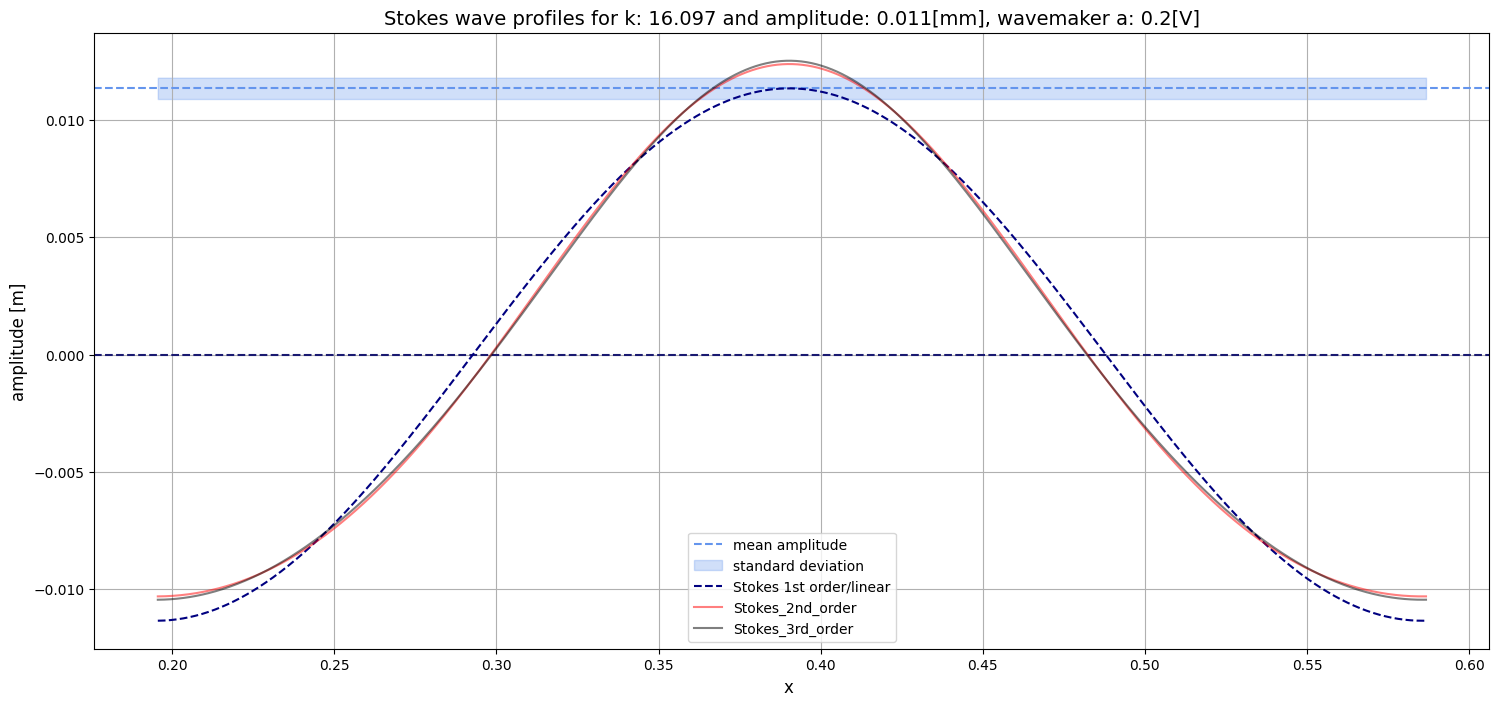

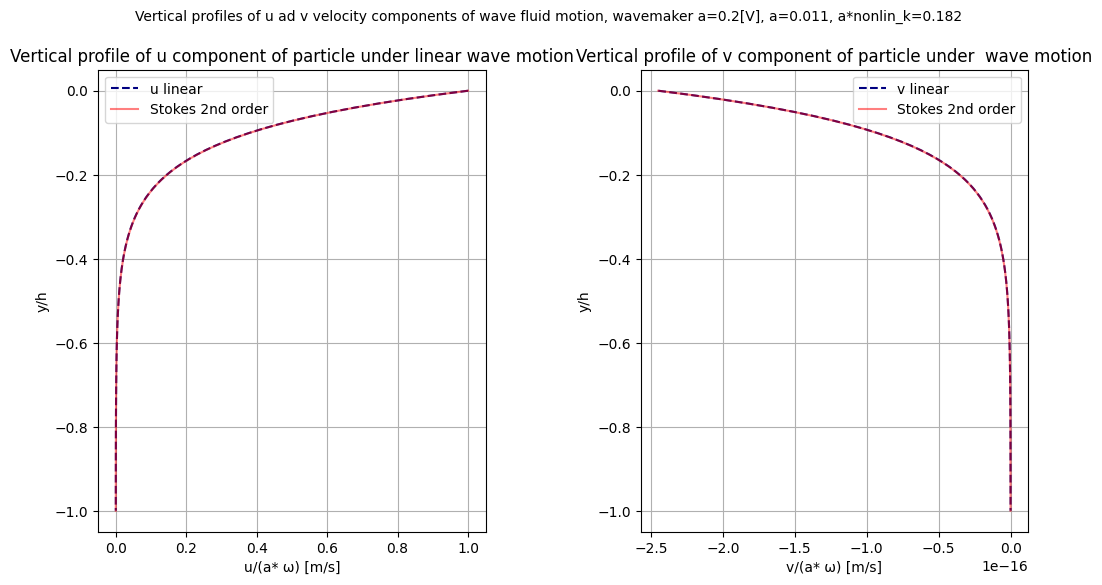

In [5]:
#0.2 V
a1 = np.array([0.011647, 0.011145, 0.011264]).mean()
a1_std = np.array([0.000398, 0.000335, 0.000628]).mean()
frequency = 2 # [Hz]
ang_freq = 2 * np.pi * frequency
k1 = get_k_from_dispersion_relation(a1, ang_freq, 1)
k3 = get_k_from_dispersion_relation(a1, ang_freq, 3)
non_linear_lambda = 2* np.pi/k3
x = np.linspace(non_linear_lambda/2, (3/2) * non_linear_lambda, 1000)

plot_stokes_up_to3rd_order(0.2, a1, a1_std, ang_freq, x )
plot_velocity_profiles(0.2, a1, ang_freq,  0.6)

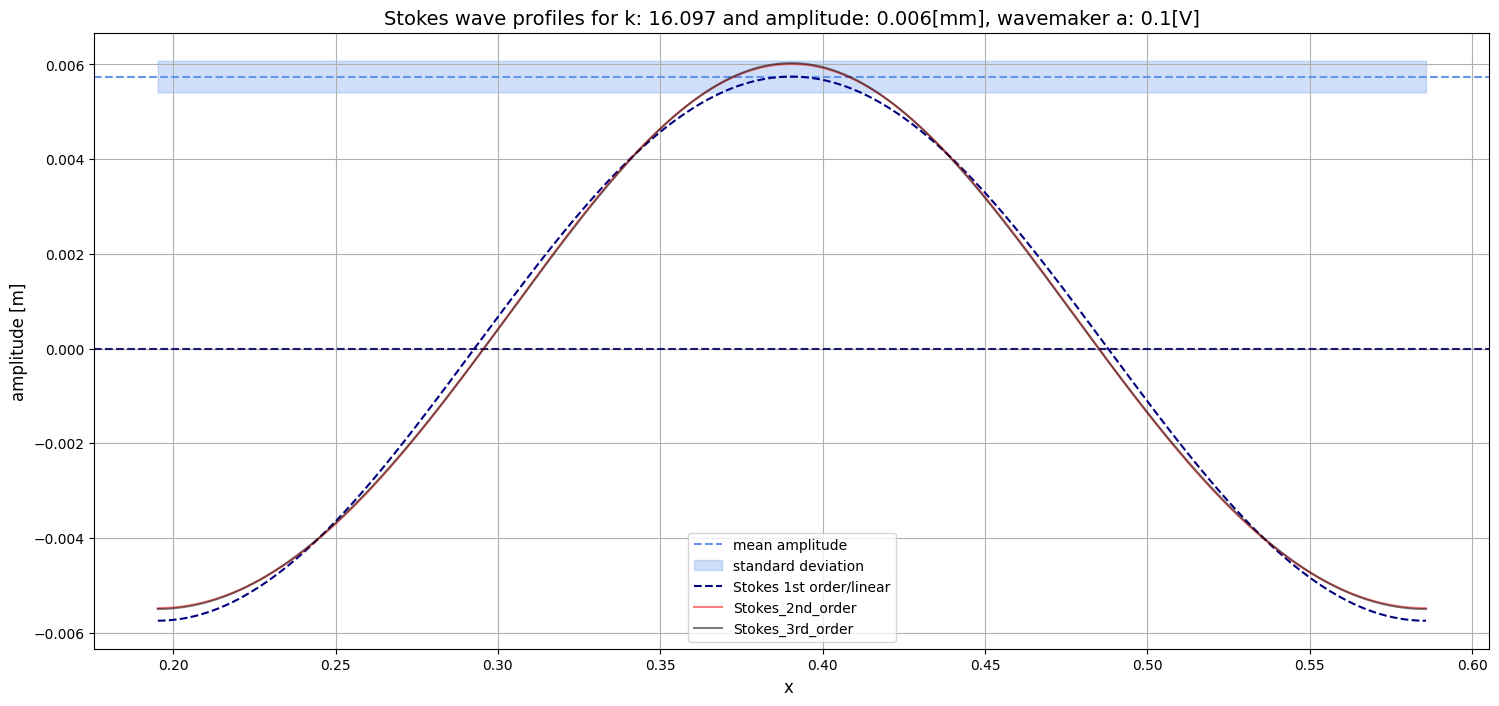

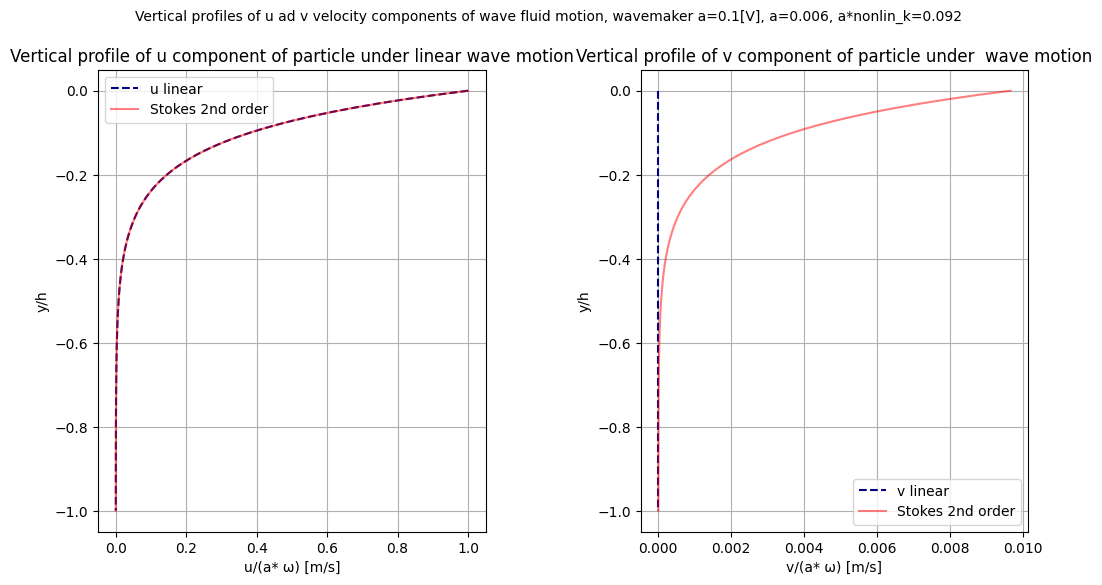

In [6]:
#0.1 V
a2 = np.array([0.005820, 0.005907, 0.005508]).mean()
a2_std = np.array([0.000186, 0.000143, 0.000675]).mean()
frequency = 2 # [Hz]
ang_freq = 2 * np.pi * frequency
k1 = get_k_from_dispersion_relation(a1, ang_freq, 1)
k3 = get_k_from_dispersion_relation(a2, ang_freq, 3)
non_linear_lambda = 2* np.pi/k3
x = np.linspace(non_linear_lambda/2, (3/2) * non_linear_lambda, 1000)
plot_stokes_up_to3rd_order(0.1, a2, a2_std, ang_freq, x )
plot_velocity_profiles(0.1, a2, ang_freq,  0.6)

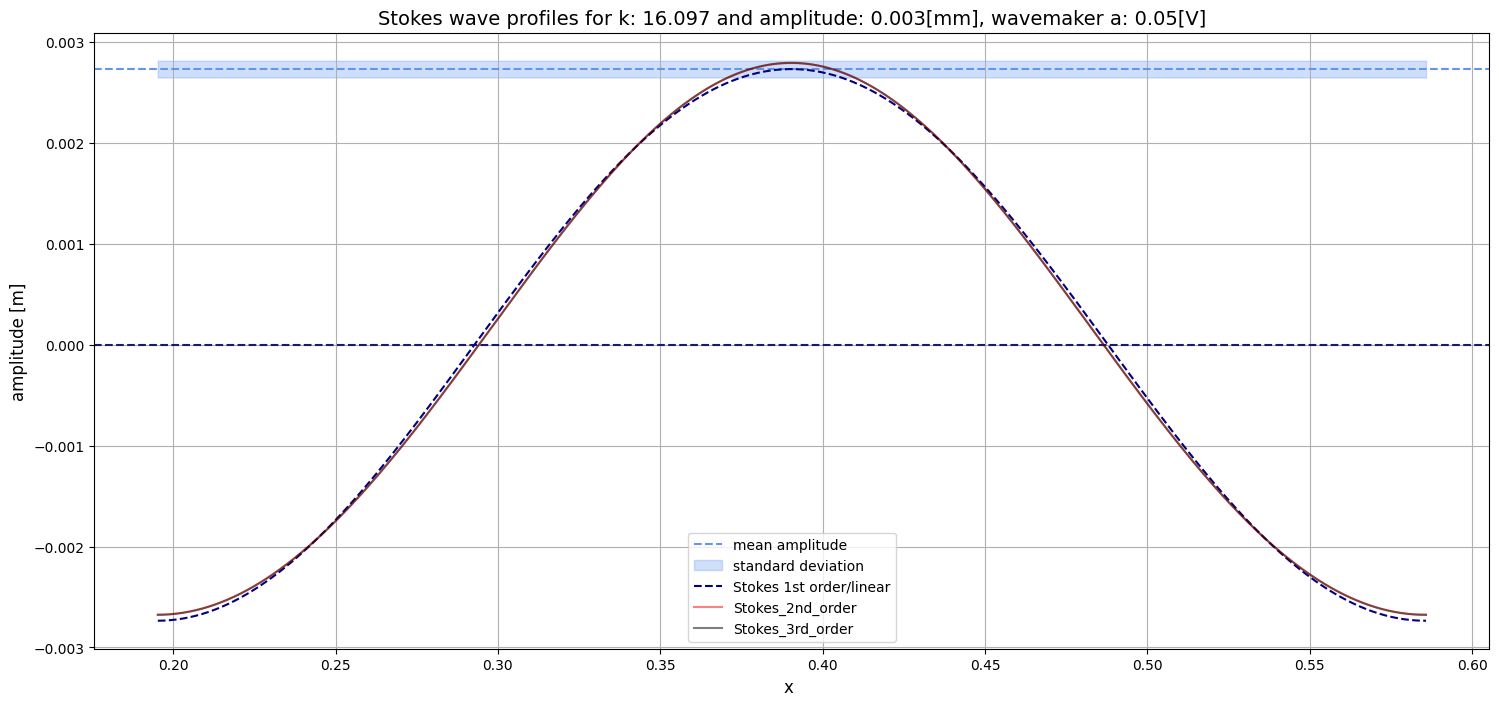

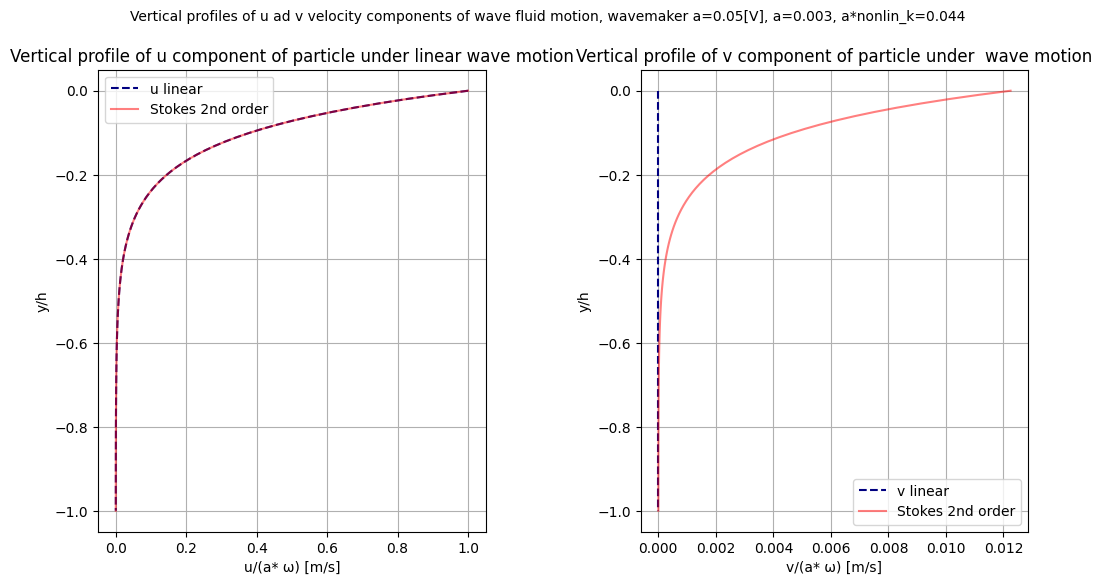

In [7]:
#0.05 V
a3 = np.array([0.002735]).mean()
a3_std = np.array([0.000083]).mean()
frequency = 2 # [Hz]
ang_freq = 2 * np.pi * frequency
k1 = get_k_from_dispersion_relation(a1, ang_freq, 1)
k3 = get_k_from_dispersion_relation(a2, ang_freq, 3)
non_linear_lambda = 2* np.pi/k3
x = np.linspace(non_linear_lambda/2, (3/2) * non_linear_lambda, 1000)
plot_stokes_up_to3rd_order(0.05, a3, a3_std, ang_freq, x )
plot_velocity_profiles(0.05, a3, ang_freq,  0.6)